In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import optuna

sns.set_theme()

In [5]:
aapl = yf.download('AAPL', start = '2020-01-01', end = '2025-05-01')

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

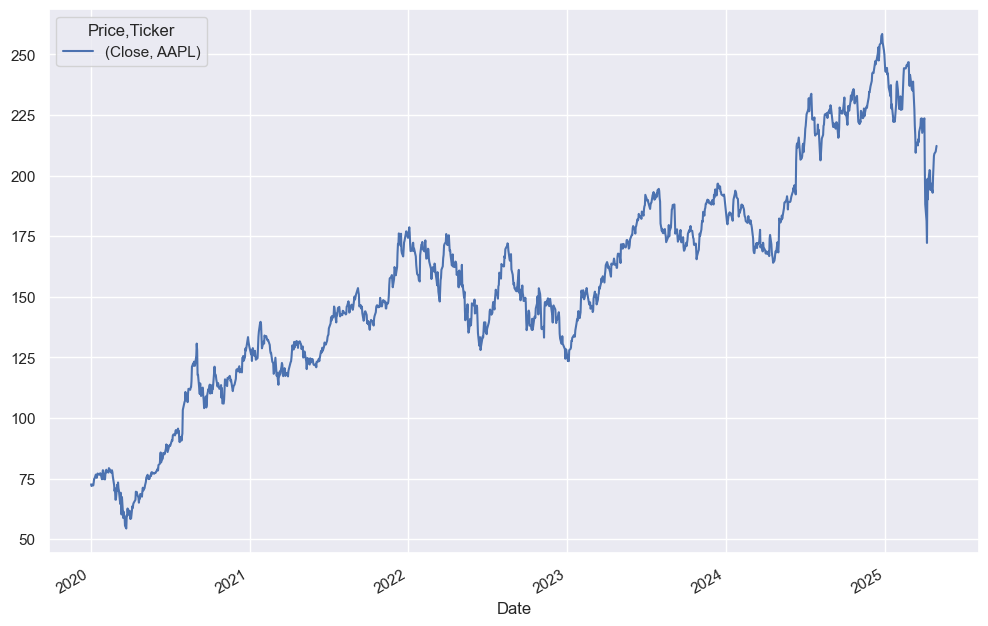

In [8]:
close_values = aapl[['Close']]
close_values.plot(kind = "line", figsize=(12,8))

In [9]:
X_train, X_test = train_test_split(close_values, shuffle = False)

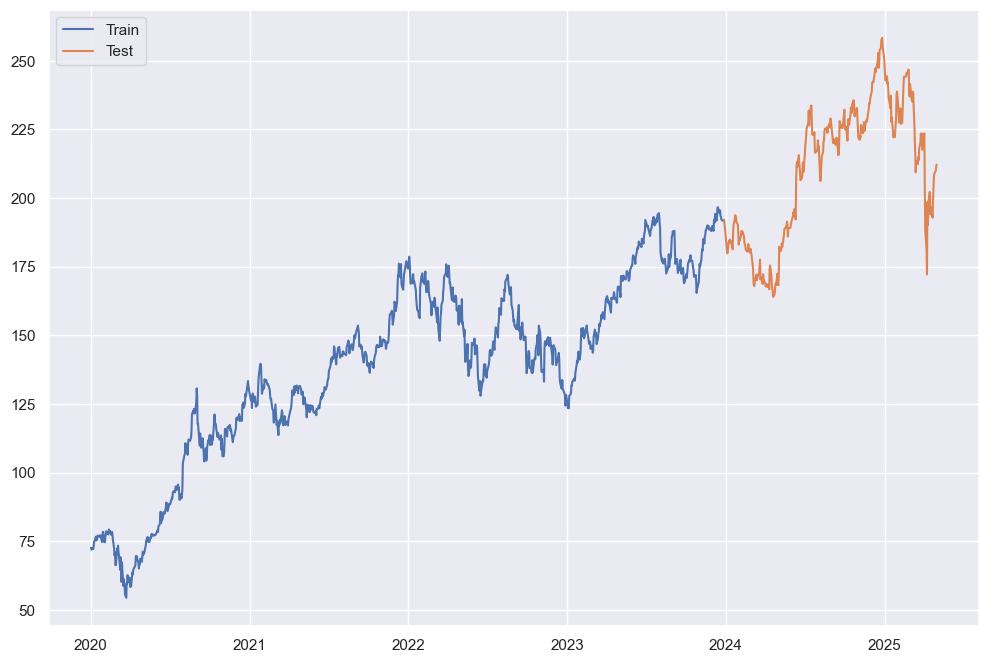

In [10]:
plt.figure(figsize = (12, 8))
plt.plot(X_train.index, X_train.values, label = 'Train')
plt.plot(X_test.index, X_test.values, label = 'Test')
plt.legend()
plt.show()

In [11]:
def prepare_to_training(data):
    for lag in [1, 2, 3]:
        data[f'lag_{lag}'] = data['Close'].shift(lag)
        data[f'dif_{lag}'] = data['Close'].diff(lag)
    data.dropna(inplace = True)

    X = data.drop('Close', axis = 1)
    y = data[['Close']]

    return X, y

In [12]:
X, y = prepare_to_training(X_train)

In [ ]:
tscv = TimeSeriesSplit(n_splits=6)
svr  = SVR(kernel = 'rbf')

In [38]:
X_vec, y_vec = X.values, y.values.reshape(-1)

def objective(trial):
    C       = trial.suggest_float('C', 1e-2, 1e2)
    gamma   = trial.suggest_categorical('gamma', ["scale", "auto", 0.01, 0.1, 1])
    epsilon = trial.suggest_float('epsilon', 1e-3, 1e0)

    mses = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X_vec[train_idx], X_vec[val_idx]
        y_tr, y_val = y_vec[train_idx], y_vec[val_idx]

        model = SVR(kernel  = 'rbf',
                    C       = C,
                    gamma   = gamma,
                    epsilon = epsilon)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_val, y_pred))

    return np.mean(mses)

In [40]:
# 4. Lanzamos el estudio
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500, timeout=600)

# 5. Resultados
print("Mejores hiperparámetros:")
for key, val in study.best_params.items():
    print(f"  - {key}: {val}")
print(f"Mejor MSE en CV: {study.best_value:.4f}")

[I 2025-05-17 13:18:33,845] A new study created in memory with name: no-name-0a16d1f2-ce4e-4e75-bf3a-1492c66929f4
[I 2025-05-17 13:18:33,884] Trial 0 finished with value: 90.0267568691038 and parameters: {'C': 6.521046242961518, 'gamma': 'scale', 'epsilon': 0.42203671399242954}. Best is trial 0 with value: 90.0267568691038.
[I 2025-05-17 13:18:33,979] Trial 1 finished with value: 1663.5026466838779 and parameters: {'C': 95.23706116425868, 'gamma': 1, 'epsilon': 0.37079191146724455}. Best is trial 0 with value: 90.0267568691038.
[I 2025-05-17 13:18:34,006] Trial 2 finished with value: 74.78478984578739 and parameters: {'C': 99.42644143300282, 'gamma': 'scale', 'epsilon': 0.6660173719479515}. Best is trial 2 with value: 74.78478984578739.
[I 2025-05-17 13:18:34,092] Trial 3 finished with value: 1476.5569864061638 and parameters: {'C': 70.53932168603473, 'gamma': 'auto', 'epsilon': 0.9104119155626653}. Best is trial 2 with value: 74.78478984578739.
[I 2025-05-17 13:18:34,172] Trial 4 fini

Mejores hiperparámetros:
  - C: 99.96966678876889
  - gamma: scale
  - epsilon: 0.00227756020233238
Mejor MSE en CV: 16.5553


In [46]:
best_params = study.best_params
best_svr = SVR(kernel="rbf", **best_params)
best_svr.fit(X, y)

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=99.96966678876889, epsilon=0.00227756020233238)

In [47]:
y_predicted = best_svr.predict(X)

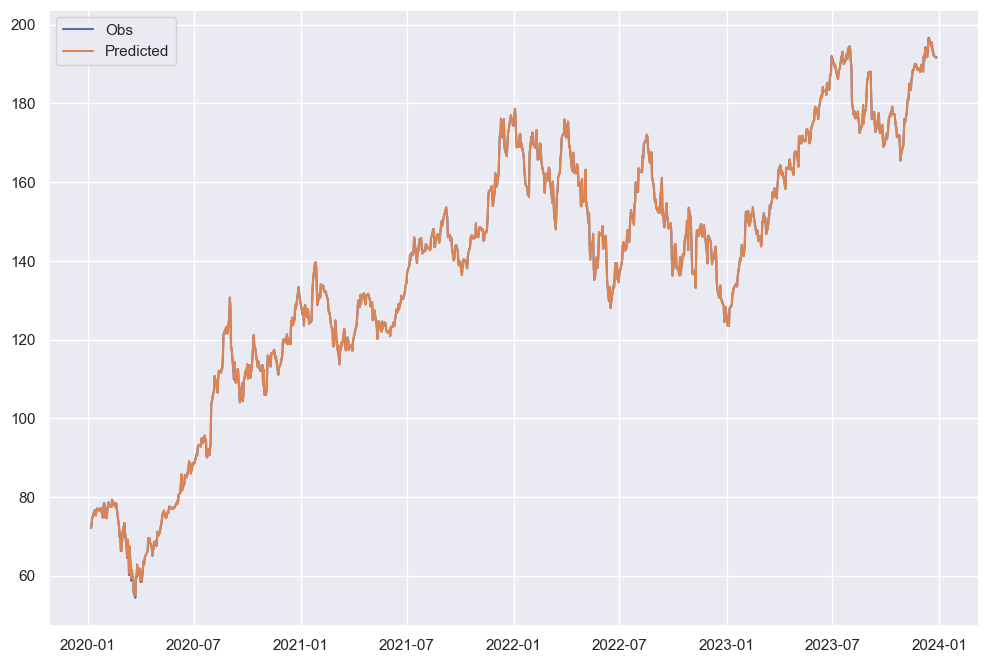

In [49]:
plt.figure(figsize = (12, 8))
plt.plot(y.index, y.values, label = 'Obs')
plt.plot(y.index, y_predicted, label = 'Predicted')
plt.legend()